### Importing modules

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,class_likelihood_ratios,confusion_matrix
import pydot # it needs Graphviz to be installed as well
import clean
import datetime
from matplotlib import pyplot as plt
import random
import seaborn as sns

### Project Configuration

In [82]:
#variables used for the creation of the corpus and the configuration of the model
ProjConfig = {
  'under_sample': False, #use undersampling of Shakespeare corpus sentences
  'under_sampling_weight': 100, #the number of sentences added to the other author's median
  'over_sample': True, #use overersampling for Marlowe corpus sentences
  'over_sampling_fraction': 1.6, #fraction of the corpus used for oversampling
  'batch_size': 16,  #number of batches for the creation of datasets
  'epochs': 6, #number of epochs for the training of the model
  'max_seq_len': 16, #sets the maximum sentence length to a value close to the median sentence length 
                     # of the corpus (BERT max is 512)
  'learning_rate': 0.0007, #sets the learning rate for ADAM optimizer
  'decay_factor': 0.0001,
  'cycles': 6, #numbers of times the training of the model will run (total no of times is cycles * epochs). 
               #This allows the model to be trained on shuffled datasets without intervention.
  'loadSavedModel' :False, # loads the saved model (or not)
  'savePath' : "c:\\model\\", # The path to the saved model
  'shuffledDataset': True # determines if a shuffled dataset will be used for training
}

In [49]:
#Checking if the GPU or CPU is supported
if 'COLAB_TPU_ADDR' in os.environ:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Using GPU


<a id="item3"></a>

# Helper Functions

### Cleaning functions

In [5]:
def cleanShakespeareText(filePath):
    with open(filePath) as file:
        lines = file.readlines()
        file.close()
    text=[]

    for line in lines:
        if line =='\n':
            continue
        
        line=clean.removeSpeakerName(line) #remove speaker's name from  each line
        line=clean.removeLinesBasedOnWords(['ACT', 'SCENE'],line) # removing lines with the words ACTS and Scenes
        line=clean.removeWords(['1','2','3','4','5','6','7','8','9'],line)
        line=clean.removeLinesBasedOnWords(['Exit'],line)
        line=clean.removeLinesBasedOnWords(['Enter'],line)
        line=clean.remove_words_in_brackets(line)
        line=clean.removeWhitespace(line)
        text.append(line)
    return text    

In [6]:
def cleanFilesinPath(playPath,cleanFilesPath):
    for play in os.scandir(playPath):
        if play.is_file():
            print((" cleaning  ") + (play.name))
            cleanedPlay=cleanShakespeareText(play.path)
            
            with open(cleanFilesPath+play.name.removesuffix('.txt')+'Cleaned'+'.txt', 'w') as cleanedFile:
                cleanedFile.write("\n".join(str(item) for item in cleanedPlay))

### Corpus creation function

In [7]:
def importPlaysinCorpus(CorpusPath,Author):
    """Imports plays in text form to the corpus dataframe (preferable cleaned)"""
    corpus=pd.DataFrame()
    for play in os.scandir(CorpusPath):
        if play.is_file():
            print((" importing  ") + (play.path) + (" to corpus"))
            newplay=pd.read_csv(play.path, delimiter='\r', header=None, names=['sentence', 'author', 'play'])
            newplay[['author']]=Author
            if 'Cleaned' in play.path:
                newplay[['play']]=os.path.basename(play.path).removesuffix('Cleaned.txt')
            else:
                newplay[['play']]=os.path.basename(play.path).removesuffix('.txt')
            corpus=pd.concat([corpus, newplay], axis = 0,join='outer')
    return corpus

In [68]:
projectCorpus=pd.DataFrame()
MarlowePath='./Corpus/Marlowe/'
ShakespearePath='./Corpus/Shakespeare/CleanedPlays/'

projectCorpus=importPlaysinCorpus(MarlowePath,'Marlowe')
projectCorpus=projectCorpus.append(importPlaysinCorpus(ShakespearePath,'Shakespeare'))
projectCorpus['sentence']=projectCorpus['sentence'].str.lower()
projectCorpus['play'] = projectCorpus['play'].apply(lambda x: x.strip())

NewProjectCorpus=projectCorpus

 importing  ./Corpus/Marlowe/Dido.txt to corpus
 importing  ./Corpus/Marlowe/DrFaustus.txt to corpus
 importing  ./Corpus/Marlowe/EdwardII.txt to corpus
 importing  ./Corpus/Marlowe/JewOfMalta.txt to corpus
 importing  ./Corpus/Marlowe/Tamburlaine1.txt to corpus
 importing  ./Corpus/Marlowe/Tamburlaine2.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/AnthonyCleopatraCleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/HenryVIIICleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/HenryVCleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/MacbethCleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/RichardIIICleaned.txt to corpus
 importing  ./Corpus/Shakespeare/CleanedPlays/HamletCleaned.txt to corpus


C:\Users\Panos\AppData\Local\Temp\ipykernel_27572\405241298.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  projectCorpus=projectCorpus.append(importPlaysinCorpus(ShakespearePath,'Shakespeare'))


### Over and under sampling corpus

the corpus is under or oversampled based on the setting of the initial cell

In [69]:
if ProjConfig['over_sample']==True:
    ShakespeareMedian=projectCorpus.loc[projectCorpus['author'] == 'Shakespeare'].play.value_counts().median()
    MarloweCorpusAddition=pd.DataFrame()
    for play in projectCorpus.loc[projectCorpus['author'] == 'Marlowe'].play.unique():
        selectedPlay=projectCorpus.loc[projectCorpus['play'] == play] 
        if selectedPlay.value_counts().sum() < ShakespeareMedian:
            selecteplaySample=selectedPlay.sample(int(selectedPlay['sentence'].value_counts().sum()/ProjConfig['over_sampling_fraction']))
            MarloweCorpusAddition=pd.concat([MarloweCorpusAddition,selecteplaySample])
            print('adding a sample from ', play, 'to Marlowe\'s corpus')
    #adding a fraction of Marlowe's corpus to increase its volume
    NewProjectCorpus=pd.concat([projectCorpus, MarloweCorpusAddition], axis = 0,join='outer')

adding a sample from  Dido to Marlowe's corpus
adding a sample from  DrFaustus to Marlowe's corpus
adding a sample from  EdwardII to Marlowe's corpus
adding a sample from  JewOfMalta to Marlowe's corpus
adding a sample from  Tamburlaine1 to Marlowe's corpus
adding a sample from  Tamburlaine2 to Marlowe's corpus


In [70]:
if ProjConfig['under_sample']==True:
    ShakespeareMedian=projectCorpus.loc[projectCorpus['author'] == 'Shakespeare'].play.value_counts().median()
    NewShakesepareCorpus=pd.DataFrame()
    MarloweMedian=projectCorpus.loc[projectCorpus['author'] == 'Marlowe'].play.value_counts().median()
    if MarloweMedian < ShakespeareMedian:
        for play in projectCorpus.loc[projectCorpus['author'] == 'Shakespeare'].play.unique():
            selectedPlay=projectCorpus.loc[projectCorpus['play'] == play]
            if selectedPlay.value_counts().sum() > MarloweMedian:
                playSample = selectedPlay.sample(int(MarloweMedian-ProjConfig['under_sampling_weight']))
                NewShakesepareCorpus=pd.concat([NewShakesepareCorpus, playSample], axis = 0,join='outer')
    #checking if over-sampled texts have been added
    if NewProjectCorpus.sentence.count()==projectCorpus.sentence.count():
        NewProjectCorpus = importPlaysinCorpus(MarlowePath,'Marlowe')        
        NewProjectCorpus = pd.concat([NewProjectCorpus, NewShakesepareCorpus], axis = 0,join='outer')
        NewProjectCorpus['sentence']=NewProjectCorpus['sentence'].str.lower()
    

### Corpus Statistics function

In [53]:
def wordsPerPlay(corpus):
    columns=['Play', 'Words Sum', 'Author']
    PlayList=[]
    for Play in corpus['play'].unique():
            PlayInLoop=(corpus.loc[corpus['play'] == Play])
            PlaySum = sum(PlayInLoop['sentence'].str.count('\w+'))
            PlayName = Play
            PlayAuthor = PlayInLoop['author'].unique()[0]
            PlayList.append([PlayName,PlaySum,PlayAuthor])
            
    WordsPerPlay=pd.DataFrame(PlayList, columns=columns)
    return WordsPerPlay

In [71]:
corpusStats=wordsPerPlay(projectCorpus)
newCorpusStats=wordsPerPlay(NewProjectCorpus)
medianSentLength = np.median(NewProjectCorpus['sentence'].apply(lambda x: len([words for words in x.split(" ") if isinstance(x, str)])))
maxSentLength = np.max(NewProjectCorpus['sentence'].apply(lambda x: len([words for words in x.split(" ") if isinstance(x, str)])))
print("Initial corpus:\n",corpusStats,"\n","New Corpus:\n",newCorpusStats)
print("initial corpus Mean:\t",corpusStats['Words Sum'].mean(),"\t","New Corpus Mean:\t",newCorpusStats['Words Sum'].mean())
print("Corpus median sentence length:\t",medianSentLength)
print("Corpus max sentence length:\t",maxSentLength)
print("Shakespeare initial corpus mean ",int(corpusStats.loc[corpusStats['Author'] == 'Shakespeare']['Words Sum'].mean()),", Shakespeare corpus mean after sampling ",int(newCorpusStats.loc[corpusStats['Author'] == 'Shakespeare']['Words Sum'].mean()))
print("Marlowe initial sampling        ",int(corpusStats.loc[corpusStats['Author'] == 'Marlowe']['Words Sum'].mean()),", Marlowe corpus mean after sampling     ",int(newCorpusStats.loc[corpusStats['Author'] == 'Marlowe']['Words Sum'].mean()))

Initial corpus:
                 Play  Words Sum       Author
0               Dido      14003      Marlowe
1          DrFaustus      12040      Marlowe
2           EdwardII      21164      Marlowe
3         JewOfMalta      19328      Marlowe
4       Tamburlaine1      17666      Marlowe
5       Tamburlaine2      17921      Marlowe
6   AnthonyCleopatra      24163  Shakespeare
7          HenryVIII      24230  Shakespeare
8             HenryV      28687  Shakespeare
9            Macbeth      16859  Shakespeare
10        RichardIII      30886  Shakespeare
11            Hamlet      29958  Shakespeare 
 New Corpus:
                 Play  Words Sum       Author
0               Dido      22718      Marlowe
1          DrFaustus      19497      Marlowe
2           EdwardII      34395      Marlowe
3         JewOfMalta      31500      Marlowe
4       Tamburlaine1      28658      Marlowe
5       Tamburlaine2      29188      Marlowe
6   AnthonyCleopatra      24163  Shakespeare
7          HenryVIII   

In [72]:
#replacing the author with 0 for Marlowe and 1 for Shakespeare
NewProjectCorpus['author'].replace(['Marlowe','Shakespeare'],[0,1],inplace=True)

### Setting the model and creating the BERT layer

In [14]:
modelURL ='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

#creating the initial layer
bert_layer = hub.KerasLayer(modelURL , trainable=False, name="BERT")
#creating the vocabulary file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
print(f'BERT vocab file location : {vocab_file}')



BERT vocab file location : b'C:\\Users\\Panos\\AppData\\Local\\Temp\\tfhub_modules\\d760773f85f64fc84ae0b47310f7cfe3bcec4868\\assets\\vocab.txt'


### Creating the Tokenizer for BERT

#### BERT vocabulary creation functions

In [15]:
def load_vocab(vocab_file):
  """Loads a vocab file into a list."""
  vocab = []
  with tf.io.gfile.GFile(vocab_file, "r") as reader:
    while True:
      token = reader.readline()
      if not token: break
      token = token.strip()
      vocab.append(token)
  return vocab

vocab = load_vocab(vocab_file)

In [16]:
def createVocabTable(vocab, num_oov=1):
  """Creates a vocabulary table """
  vocabValues = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocab, values=vocabValues, key_dtype=tf.string, value_dtype=tf.int64)
  vocabTable = tf.lookup.StaticVocabularyTable(init, num_oov, lookup_key_dtype=tf.string)
  return vocabTable


In [17]:
vocabLookupTable = createVocabTable(vocab)

In [18]:
def createIndex2Word(vocab):
  """Creates a lookup table for index to token"""
  vocabValues = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocabValues, values=vocab)
  return tf.lookup.StaticHashTable(initializer=init, default_value=tf.constant('unk'), name="index2word")

#### BERT Tokenizer functions

In [19]:
#initialization of the tokenizer with its settings
tokenizer = text.BertTokenizer( 
    vocabLookupTable,
    suffix_indicator = "##",
    max_bytes_per_word = 100,
    max_chars_per_token=None,
    unknown_token = '[UNK]',
    token_out_type=tf.int64,
    lower_case=False,
    preserve_unused_token = False,    
  )

In [ ]:
#testing to see if the vocabulary contains BERT tokens, new line and some words
vocabLookupTable.lookup(tf.constant(['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '\n', 'I', 'were']))

In [21]:
PAD_ID = vocabLookupTable.lookup(tf.constant('[PAD]')) # padding token
CLS_ID = vocabLookupTable.lookup(tf.constant('[CLS]')) # class token
SEP_ID = vocabLookupTable.lookup(tf.constant('[SEP]')) # sentence separator token
def tokenize_text(sentence, seq_len):
  # convert text into token ids
  tokens = tokenizer.tokenize(sentence)
  # flatten the output ragged tensors
  tokens = tokens.merge_dims(1, 2)[:, :seq_len]
  # Add start and end token ids to the id sequence
  startTokens = tf.fill([tf.shape(sentence)[0], 1], CLS_ID)
  endTokens = tf.fill([tf.shape(sentence)[0], 1], SEP_ID)
  tokens = tokens[:, :seq_len - 2]
  tokens = tf.concat([startTokens, tokens, endTokens], axis=1)
  # truncate sequences greater than MAX_SEQ_LEN
  tokens = tokens[:, :seq_len]
  # pad shorter sequences with the pad token id
  tokens = tokens.to_tensor(default_value=PAD_ID)
  pad = seq_len - tf.shape(tokens)[1]
  tokens = tf.pad(tokens, [[0, 0], [0, pad]], constant_values=PAD_ID)

  # reshaping the word token ids to fit the output 
  return tf.reshape(tokens, [-1, seq_len])

#### Testing the tokenization function

In [58]:
tokens=tokenize_text(projectCorpus['sentence'][1000:1010].values, 10)
tokenizer.detokenize(tokens)

<tf.RaggedTensor [[b'[CLS]', b'how', b'long', b'shall', b'i', b'with', b'grief', b'consume',
  b'my', b'[SEP]']                                                         ,
 [b'[CLS]', b'iarbas', b',', b'talk', b'not', b'of', b'ae', b'[SEP]'],
 [b'[CLS]', b'that', b'shall', b'consume', b'all', b'that', b'this',
  b'stranger', b'left', b'[SEP]']                                   ,
 [b'[CLS]', b'to', b'cure', b'my', b'mind', b'that', b'melts', b'for',
  b'[SEP]']                                                           ,
 [b'[CLS]', b'but', b'afterwards', b'will', b'dido', b'grant', b'me',
  b'love', b'[SEP]']                                                 ,
 [b'[CLS]', b'ay', b',', b'ay', b',', b'iarba', b'[SEP]'],
 [b'[CLS]', b'so', b',', b'leave', b'me', b'now', b',', b'let', b'none',
  b'[SEP]']                                                             ,
 [b'[CLS]', b'now', b'dido', b',', b'with', b'these', b'relics', b'burn',
  b'[SEP]']                                             

#### Preprocessing Functions

In [23]:
def preprocessBERTInput(tokens,seq_len):
  # calculating the mask
  mask = tf.cast(tokens > 0, tf.int64)
  mask = tf.reshape(mask, [-1, seq_len])
  # calculating the token type ID
  zeros_dims = tf.stack(tf.shape(mask))
  type_ids = tf.fill(zeros_dims, 0)
  type_ids = tf.cast(type_ids, tf.int64)
  return (mask, type_ids)


In [24]:
def PreProcess(sentence, author, seq_len):
  # calculate token IDs
  ids = tokenize_text(sentence, seq_len)
  # process review to calculate BERT input
  mask, type_ids = preprocessBERTInput(ids,seq_len)
  return  (ids, mask, type_ids),author


### Dataset creation for training, testing and validation

In [25]:
def createDataset(Dataset,BatchSize,max_seq_len):
    """Preprocesses the corpus to produce the input for BERT,
       creates a batched tensorflow dataset with prefetch """
    result = PreProcess(Dataset['sentence'].values,Dataset['author'].values,max_seq_len)
    result = tf.data.Dataset.from_tensor_slices(result)
    result = result.batch(BatchSize)
    result = result.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return result

In [26]:
def createValDataset(corpus):
    """creates a continuous validation sample with a random start"""
    validate=pd.DataFrame()
    for play in corpus['play'].unique():
                Selectedplay=corpus.loc[corpus['play'] == play]
                count=round(corpus.loc[corpus['play'] == play]['sentence'].count())
                sample=round(count*0.2)
                ValSelection=random.randrange(0,count-sample)
                validate=pd.concat([validate,Selectedplay[ValSelection:ValSelection+sample]])
    return validate

In [27]:
def createShuffledDatasets(corpus, shuffleState):
    if (shuffleState ==True):
        train, unused = train_test_split(corpus, test_size=0.0005, shuffle=True,stratify= corpus['play'])
        validate=createValDataset(corpus)
    elif (shuffleState == False):
        train, unused = train_test_split(corpus, test_size=0.0005, shuffle=False)
        validate=createValDataset(corpus)

    trainDataset=createDataset(train,ProjConfig['batch_size'],ProjConfig['max_seq_len'])
    EvalDataset=createDataset(validate,ProjConfig['batch_size'],ProjConfig['max_seq_len'])
   
    return trainDataset,EvalDataset
    

### Model creation and training

In [73]:
def createModel(maxSeqLen,learningRate,decayFactor):
    input_word_ids = tf.keras.layers.Input(shape=(maxSeqLen,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(maxSeqLen,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(maxSeqLen,), dtype=tf.int32, name="input_type_ids")
    
    bert_inputs = dict(
        input_word_ids=input_word_ids,
        input_mask=input_mask,
        input_type_ids=input_type_ids)
    #adding the layers
    pooled_output = bert_layer(bert_inputs)['pooled_output'] #creates the layer for the three inputs
    Dropout = tf.keras.layers.Dropout(0.005, name="dropout")(pooled_output,training=True) #creates the dropout layer, to prevent overfitting (used only during training)
    Output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(Dropout) # only 2 classes, using sigmoid for activation
    
    #configuring the optimizer
    optimizer=tf.keras.optimizers.legacy.Adam(
        learning_rate=learningRate , #default 0.001
        #beta_1=0.9,
        #beta_2=0.999,
        #epsilon= 1e-4 ,
        amsgrad=False,
        name='Adam',
        decay=decayFactor
    )

    model = tf.keras.Model(inputs=bert_inputs, outputs = Output)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
    print(model.summary())
    return model
    

In [83]:
model=createModel(ProjConfig['max_seq_len'],ProjConfig['learning_rate'],ProjConfig['decay_factor'])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 16)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 16)]         0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 16)]         0           []                               
                                                                                                  
 BERT (KerasLayer)              {'sequence_output':  109482241   ['input_mask[0][0]',             
                                 (None, 16, 768),                 'input_type_ids[0][0]',   

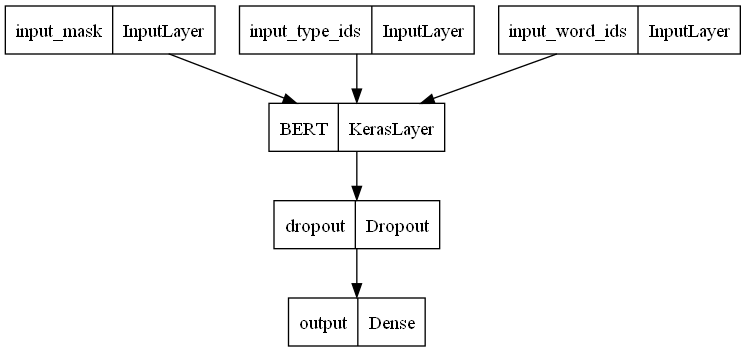

In [30]:
tf.keras.utils.plot_model(model)

In [31]:
def trainModel (epochsNumber,cycles, loadPresaved):
    history=pd.DataFrame()
    for cycle in range(cycles):
     
        print(f'Cycle number: {cycle+1}')
        trainDataset,EvalDataset=createShuffledDatasets(NewProjectCorpus,ProjConfig['shuffledDataset'])
        #
        checkpoint_path = ProjConfig['savePath']
        checkpoint_dir = os.path.dirname(checkpoint_path)

        # Create a callback that saves the model's weights
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                save_weights_only=True,
                                                                verbose=1)
        if (loadPresaved == True):
            #loads the model from the checkpoint path
            model.load_weights(checkpoint_path)

        #Tuning decay via Learning rate 
        def TuneLearningRate(epochsNumber,rate):
            if epoch < 6 :#or cycle < 0 :
                return rate
            else:
                return rate * tf.math.exp(-0.0001)

        #create callbcak for the learning rate scheduler
        scheduler = tf.keras.callbacks.LearningRateScheduler(TuneLearningRate)

        results=model.fit(trainDataset,
                    epochs=epochsNumber,
                    validation_data=EvalDataset,
                    #callbacks=[checkpoint_callback,scheduler]
                    callbacks=[checkpoint_callback]
                    )
        history=history.append(results.history, ignore_index=True)
    return history

In [88]:
results=trainModel(ProjConfig['epochs'], ProjConfig['cycles'],ProjConfig['loadSavedModel'])

Cycle number: 1
Epoch 1/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6898 - accuracy: 0.5315
Epoch 1: saving model to c:\model\
2615/2615 [==============================] - 129s 49ms/step - loss: 0.6898 - accuracy: 0.5315 - val_loss: 0.6910 - val_accuracy: 0.5290
Epoch 2/6
2615/2615 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.5329
Epoch 2: saving model to c:\model\
2615/2615 [==============================] - 129s 49ms/step - loss: 0.6898 - accuracy: 0.5329 - val_loss: 0.6907 - val_accuracy: 0.5315
Epoch 3/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6896 - accuracy: 0.5310
Epoch 3: saving model to c:\model\
2615/2615 [==============================] - 125s 48ms/step - loss: 0.6896 - accuracy: 0.5310 - val_loss: 0.6908 - val_accuracy: 0.5270
Epoch 4/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6896 - accuracy: 0.5323
Epoch 4: saving model to c:\model\
2615/2615 [==============================] - 122

C:\Users\Panos\AppData\Local\Temp\ipykernel_27572\13558542.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(results.history, ignore_index=True)


Epoch 1/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6895 - accuracy: 0.5332
Epoch 1: saving model to c:\model\
2615/2615 [==============================] - 122s 47ms/step - loss: 0.6895 - accuracy: 0.5332 - val_loss: 0.6903 - val_accuracy: 0.5303
Epoch 2/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6898 - accuracy: 0.5317
Epoch 2: saving model to c:\model\
2615/2615 [==============================] - 122s 47ms/step - loss: 0.6898 - accuracy: 0.5317 - val_loss: 0.6904 - val_accuracy: 0.5303
Epoch 3/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6897 - accuracy: 0.5314
Epoch 3: saving model to c:\model\
2615/2615 [==============================] - 124s 47ms/step - loss: 0.6897 - accuracy: 0.5314 - val_loss: 0.6909 - val_accuracy: 0.5260
Epoch 4/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6895 - accuracy: 0.5334
Epoch 4: saving model to c:\model\
2615/2615 [==============================] - 123s 47ms/step - lo

C:\Users\Panos\AppData\Local\Temp\ipykernel_27572\13558542.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(results.history, ignore_index=True)


Epoch 1/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6896 - accuracy: 0.5304
Epoch 1: saving model to c:\model\
2615/2615 [==============================] - 118s 45ms/step - loss: 0.6896 - accuracy: 0.5303 - val_loss: 0.6889 - val_accuracy: 0.5350
Epoch 2/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6897 - accuracy: 0.5313
Epoch 2: saving model to c:\model\
2615/2615 [==============================] - 115s 44ms/step - loss: 0.6897 - accuracy: 0.5313 - val_loss: 0.6887 - val_accuracy: 0.5343
Epoch 3/6
2615/2615 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5300
Epoch 3: saving model to c:\model\
2615/2615 [==============================] - 121s 46ms/step - loss: 0.6897 - accuracy: 0.5300 - val_loss: 0.6887 - val_accuracy: 0.5372
Epoch 4/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6896 - accuracy: 0.5320
Epoch 4: saving model to c:\model\
2615/2615 [==============================] - 117s 45ms/step - lo

C:\Users\Panos\AppData\Local\Temp\ipykernel_27572\13558542.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(results.history, ignore_index=True)


Epoch 1/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6894 - accuracy: 0.5326
Epoch 1: saving model to c:\model\
2615/2615 [==============================] - 120s 46ms/step - loss: 0.6894 - accuracy: 0.5326 - val_loss: 0.6886 - val_accuracy: 0.5331
Epoch 2/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.5319
Epoch 2: saving model to c:\model\
2615/2615 [==============================] - 121s 46ms/step - loss: 0.6893 - accuracy: 0.5320 - val_loss: 0.6887 - val_accuracy: 0.5326
Epoch 3/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.5313
Epoch 3: saving model to c:\model\
2615/2615 [==============================] - 120s 46ms/step - loss: 0.6893 - accuracy: 0.5313 - val_loss: 0.6886 - val_accuracy: 0.5387
Epoch 4/6
2615/2615 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5335
Epoch 4: saving model to c:\model\
2615/2615 [==============================] - 125s 48ms/step - lo

C:\Users\Panos\AppData\Local\Temp\ipykernel_27572\13558542.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(results.history, ignore_index=True)


Epoch 1/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.5362
Epoch 1: saving model to c:\model\
2615/2615 [==============================] - 126s 48ms/step - loss: 0.6893 - accuracy: 0.5362 - val_loss: 0.6909 - val_accuracy: 0.5312
Epoch 2/6
2615/2615 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5354
Epoch 2: saving model to c:\model\
2615/2615 [==============================] - 121s 46ms/step - loss: 0.6893 - accuracy: 0.5354 - val_loss: 0.6908 - val_accuracy: 0.5306
Epoch 3/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6895 - accuracy: 0.5337
Epoch 3: saving model to c:\model\
2615/2615 [==============================] - 122s 47ms/step - loss: 0.6895 - accuracy: 0.5337 - val_loss: 0.6900 - val_accuracy: 0.5330
Epoch 4/6
2615/2615 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5348
Epoch 4: saving model to c:\model\
2615/2615 [==============================] - 116s 44ms/step - lo

C:\Users\Panos\AppData\Local\Temp\ipykernel_27572\13558542.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(results.history, ignore_index=True)


Epoch 1/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.5348
Epoch 1: saving model to c:\model\
2615/2615 [==============================] - 115s 44ms/step - loss: 0.6892 - accuracy: 0.5348 - val_loss: 0.6892 - val_accuracy: 0.5362
Epoch 2/6
2614/2615 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.5359
Epoch 2: saving model to c:\model\
2615/2615 [==============================] - 115s 44ms/step - loss: 0.6893 - accuracy: 0.5359 - val_loss: 0.6889 - val_accuracy: 0.5356
Epoch 3/6
2615/2615 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5340
Epoch 3: saving model to c:\model\
2615/2615 [==============================] - 115s 44ms/step - loss: 0.6891 - accuracy: 0.5340 - val_loss: 0.6887 - val_accuracy: 0.5368
Epoch 4/6
2615/2615 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5349
Epoch 4: saving model to c:\model\
2615/2615 [==============================] - 115s 44ms/step - lo

C:\Users\Panos\AppData\Local\Temp\ipykernel_27572\13558542.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(results.history, ignore_index=True)


In [33]:
def plotTrainingResults(results):
    for name in results.columns:
        counter=0
        plt.figure(figsize=(7,9))
        for x1 in ( results[name]):
            counter+=1
            plt.plot(x1, label='cycle '+str(counter) )
            plt.title(name, fontweight="bold")
            plt.suptitle(
                        'Learning rate: '+ str((ProjConfig['learning_rate']))+'\n'
                        'Decay factor: '+ str((ProjConfig['decay_factor']))+'\n'
                        'Max Sequence Length: '+ str((ProjConfig['max_seq_len']))+'\n'
                        
                        )
            plt.legend(loc='right')
            plt.xlabel('epochs', fontweight="bold")
        plt.show()

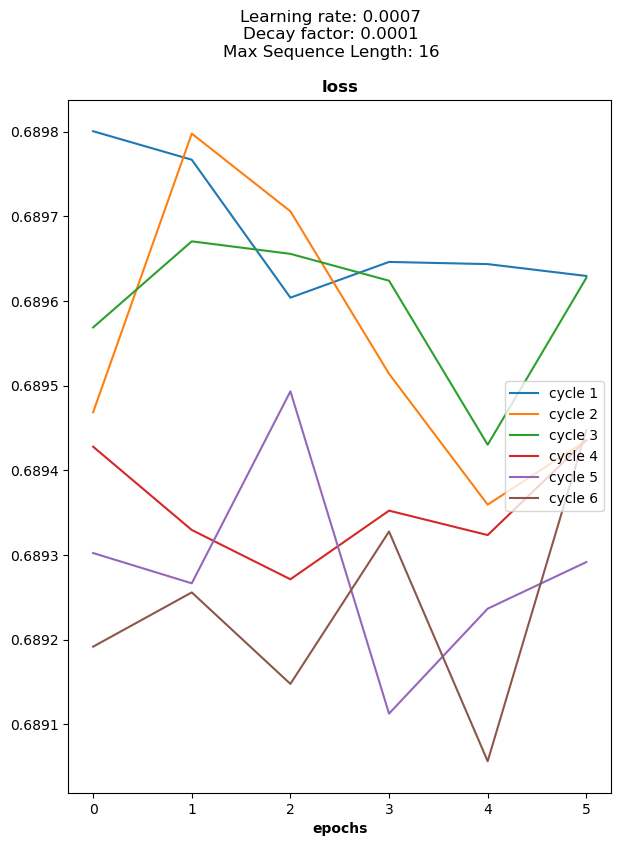

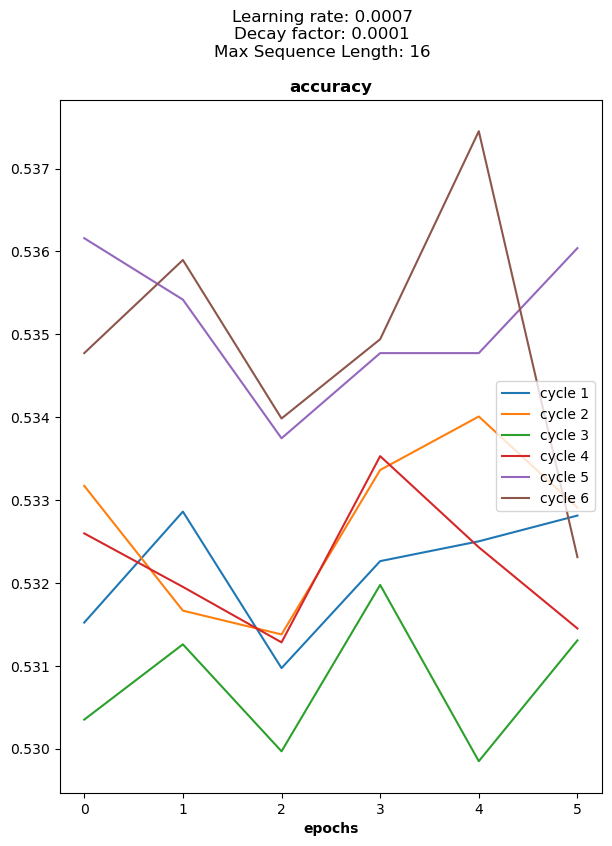

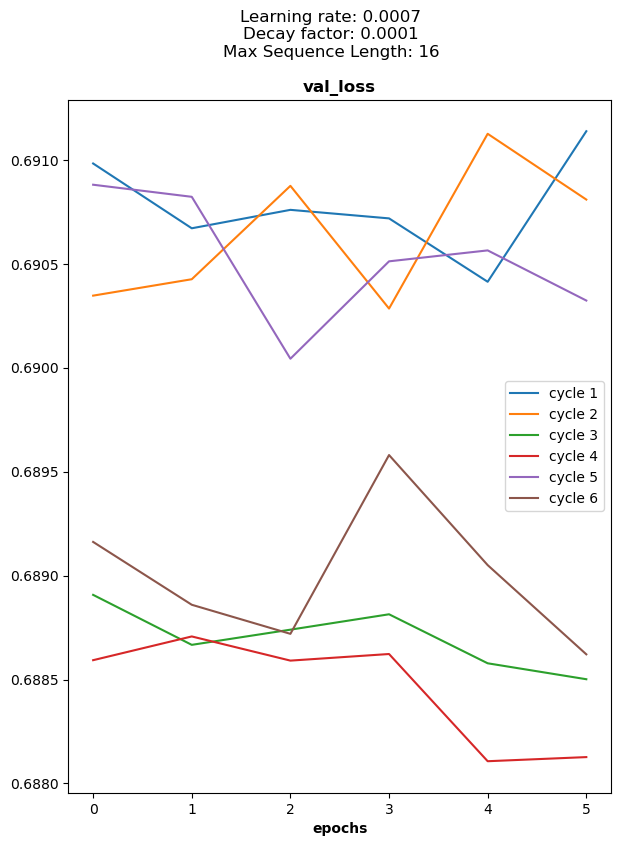

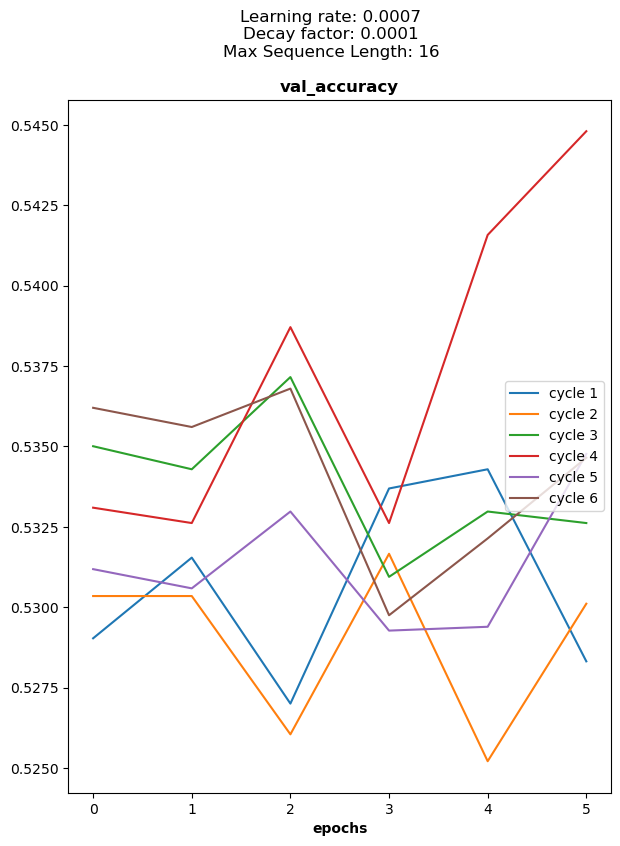

In [89]:
plotTrainingResults(results)

### Creating the Test Corpus

The test corpus consists of one unseen and on already seen text during the training of the model

In [37]:
OriginalShakespearePath='./Corpus/TestTexts/Shakespeare/'
CleanShakespearePath='./Corpus/TestTexts/Shakespeare/CleanedPlays/'
cleanFilesinPath(OriginalShakespearePath,CleanShakespearePath)


 cleaning  Othello.txt
 cleaning  Macbeth.txt


In [90]:
ShakespeareUnseenPath='./Corpus/TestTexts/Shakespeare/CleanedPlays/'
MarloweUnseenPath='./Corpus/TestTexts/Marlowe/'
ShakespeareUnseen=pd.DataFrame()

ShakespeareUnseen=importPlaysinCorpus(ShakespeareUnseenPath,'Shakespeare')
ShakespeareUnseen['sentence']=ShakespeareUnseen['sentence'].str.lower()

MarloweUnseen=importPlaysinCorpus(MarloweUnseenPath,'Marlowe')
MarloweUnseen['sentence']=MarloweUnseen['sentence'].str.lower()
Unseen=pd.DataFrame()
Unseen=pd.concat([Unseen,MarloweUnseen],axis=0, join="outer")
Unseen=pd.concat([Unseen,ShakespeareUnseen],axis=0, join="outer")
#shuffling line in the dataframe
#Unseen=Unseen.sample(frac = 1)
#replacing the author with 0 for Marlowe and 1 for Shakespeare
Unseen['author'].replace(['Marlowe','Shakespeare'],[0,1],inplace=True)

 importing  ./Corpus/TestTexts/Shakespeare/CleanedPlays/OthelloCleaned.txt to corpus
 importing  ./Corpus/TestTexts/Shakespeare/CleanedPlays/MacbethCleaned.txt to corpus
 importing  ./Corpus/TestTexts/Marlowe/MassacreParis.txt to corpus
 importing  ./Corpus/TestTexts/Marlowe/EdwardII.txt to corpus


In [91]:

UnseenDataset=createDataset(Unseen,ProjConfig['batch_size'],ProjConfig['max_seq_len'])
Predictions =model.predict(UnseenDataset)
PredictionsList=[]
PredictionsList.append(Predictions)


Unseen['predictions']=PredictionsList[0]
Unseen['predictionsRounded']=Unseen['predictions'].apply(round)

639/639 [==============================] - 24s 37ms/step


In [92]:
Unseen.head(20)

,sentence,author,play,predictions,predictionsRounded
0,the massacre at paris.,0,MassacreParis,0.499384,0
1,with the death of the,0,MassacreParis,0.517131,1
2,duke of guise.,0,MassacreParis,0.524523,1
3,"enter charles the french king, the queen mother,",0,MassacreParis,0.568659,1
4,"the king of navarre, the prince of cond',",0,MassacreParis,0.505741,1
5,"the lord high admiral, and the queen of navarre,",0,MassacreParis,0.508346,1
6,with others.,0,MassacreParis,0.526306,1
7,"prince of navarre my honorable brother,",0,MassacreParis,0.506364,1
8,"prince cond', and my good lord",0,MassacreParis,0.513362,1
9,"admiral,",0,MassacreParis,0.571047,1


In [93]:
PredictionsStats=[]
PredictionsStats=Unseen.loc[Unseen['author'] != Unseen['predictionsRounded']].play.value_counts()
PredictionsStats.columns=['author','Not Correct']
PredictionsStats=PredictionsStats.to_frame(name='Not Correct')

PredictionsStats['Correct']=Unseen.loc[Unseen['author'] == Unseen['predictionsRounded']].play.value_counts()
PredictionsStats['Accuracy']=PredictionsStats['Correct']/(PredictionsStats['Correct']+PredictionsStats['Not Correct'])
PredictionsStats

,Not Correct,Correct,Accuracy
EdwardII,1468,1428,0.493094
Othello,1430,2002,0.583333
Macbeth,952,1419,0.598482
MassacreParis,800,718,0.472991


In [94]:
#
class_likelihood_ratios(Unseen['author'],Unseen['predictionsRounded'],labels=(0,1))

(1.1473337849637464, 0.8442902962265717)

In [95]:
OriginalFinalUnseenPath='./Corpus/FinalUnseen/'
CleanFinalUnseenPath='./Corpus/FinalUnseen/Cleaned/'
cleanFilesinPath(OriginalFinalUnseenPath,CleanFinalUnseenPath)

 cleaning  HenrVIPart1.txt
 cleaning  HenrVIPart3.txt
 cleaning  HenrVIPart2.txt


In [96]:
FinalUnseenPath='./Corpus/FinalUnseen/Cleaned/'

FinalUnseen=pd.DataFrame()

FinalUnseen=importPlaysinCorpus(FinalUnseenPath,'Shakespeare')
FinalUnseen['sentence']=FinalUnseen['sentence'].str.lower()

#shuffling line in the dataframe
#Unseen=Unseen.sample(frac = 1)
#replacing the author with 0 for Marlowe and 1 for Shakespeare
FinalUnseen['author'].replace(['Shakespeare'],[1],inplace=True)

 importing  ./Corpus/FinalUnseen/Cleaned/HenrVIPart1Cleaned.txt to corpus
 importing  ./Corpus/FinalUnseen/Cleaned/HenrVIPart3Cleaned.txt to corpus
 importing  ./Corpus/FinalUnseen/Cleaned/HenrVIPart2Cleaned.txt to corpus


In [44]:
FinalUnseen.head(20)

,sentence,author,play
0,:,1,HenrVIPart1
1,england and france,1,HenrVIPart1
2,the first part of king henry the sixth,1,HenrVIPart1
3,. .,1,HenrVIPart1
4,westminster abbey,1,HenrVIPart1
5,"attended on by the , regent of france,",1,HenrVIPart1
6,"the , protector, the ,",1,HenrVIPart1
7,"the , the",1,HenrVIPart1
8,"hung be the heavens with black, yield day to",1,HenrVIPart1
9,"night! comets, importing change of times and s...",1,HenrVIPart1


In [97]:
FinalUnseenDataset=createDataset(FinalUnseen,ProjConfig['batch_size'],ProjConfig['max_seq_len'])
Predictions =model.predict(FinalUnseenDataset)
FinalPredictionsList=[]
FinalPredictionsList.append(Predictions)


FinalUnseen['predictions']=FinalPredictionsList[0]
FinalUnseen['predictionsRounded']=FinalUnseen['predictions'].apply(round)

565/565 [==============================] - 21s 38ms/step


In [46]:
FinalUnseen

,sentence,author,play,predictions,predictionsRounded
0,:,1,HenrVIPart1,0.548692,1
1,england and france,1,HenrVIPart1,0.503664,1
2,the first part of king henry the sixth,1,HenrVIPart1,0.412537,0
3,. .,1,HenrVIPart1,0.720826,1
4,westminster abbey,1,HenrVIPart1,0.530541,1
...,...,...,...,...,...
3066,"now, by my hand, lords, ’twas a glorious day.",1,HenrVIPart2,0.557789,1
3067,saint albans battle won by famous york,1,HenrVIPart2,0.489472,0
3068,shall be eternized in all age to come.,1,HenrVIPart2,0.488688,0
3069,"sound drums and trumpets, and to london all;",1,HenrVIPart2,0.505192,1


In [98]:
FinalPredictionsStats=[]
FinalPredictionsStats=FinalUnseen.loc[FinalUnseen['author'] != FinalUnseen['predictionsRounded']].play.value_counts()
FinalPredictionsStats.columns=['author','Marlowe']
FinalPredictionsStats=FinalPredictionsStats.to_frame(name='Marlowe')

FinalPredictionsStats['Shakespeare']=FinalUnseen.loc[FinalUnseen['author'] == FinalUnseen['predictionsRounded']].play.value_counts()
FinalPredictionsStats['Shakespeare %']=(FinalPredictionsStats['Shakespeare']/(FinalPredictionsStats['Shakespeare']+FinalPredictionsStats['Marlowe']))*100
FinalPredictionsStats['Marlowe %']=(FinalPredictionsStats['Marlowe']/(FinalPredictionsStats['Marlowe']+FinalPredictionsStats['Shakespeare']))*100
FinalPredictionsStats

,Marlowe,Shakespeare,Shakespeare %,Marlowe %
HenrVIPart3,1504,1565,50.993809,49.006191
HenrVIPart2,1487,1584,51.579290,48.420710
HenrVIPart1,1389,1510,52.086927,47.913073


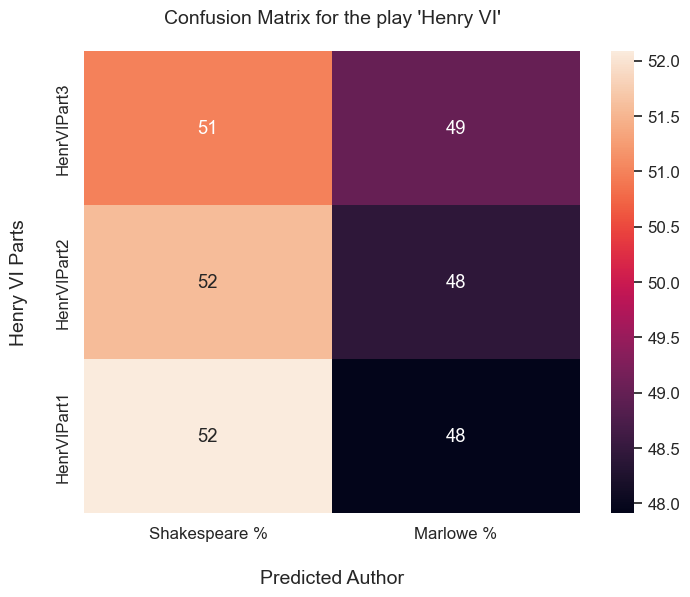

In [99]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)
ax = sns.heatmap(FinalPredictionsStats[['Shakespeare %','Marlowe %']], annot=True,)

# set x-axis label
ax.set_xlabel("Predicted Author", fontsize=14, labelpad=20)

# set y-axis label
ax.set_ylabel("Henry VI Parts", fontsize=14, labelpad=20)

# set plot title
ax.set_title("Confusion Matrix for the play 'Henry VI'", fontsize=14, pad=20)

plt.show()